# 1. Import Libraries and Set Directory

Import Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install tensorflow-io

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# directory management
import os
from glob import glob
# regular imports
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
# audio analysis
import librosa 
import librosa.display
import IPython.display as ipd
# imports for colors and plots
from itertools import cycle
sns.set_theme(style="white", palette=None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])
# imports for NN
import tensorflow as tf 
import tensorflow_io as tfio
from tensorflow import keras
from keras import backend as k
import time
from tensorflow.keras.callbacks import EarlyStopping

# 2. Process Dataset into Spectogram

a function that returns audio in numeric representation

In [4]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels) 
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    #wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

Read all audio files and sort

In [5]:
train_dir = os.path.join('/content','drive','MyDrive','audio-data', 'Train')
test_dir = os.path.join('/content','drive','MyDrive','audio-data', 'Test')
# load files
train_files = tf.data.Dataset.list_files(train_dir+'/*.wav')
test_files = tf.data.Dataset.list_files(test_dir+'/*.wav')
# sort files as a list
train_files_list = sorted(list(train_files.as_numpy_iterator()))
test_files_list = sorted(list(test_files.as_numpy_iterator()))
# convert to tensor type
train_files = tf.data.Dataset.from_tensor_slices(train_files_list)
test_files = tf.data.Dataset.from_tensor_slices(test_files_list)

Add Labels

In [6]:
num_classes = 10
iterations = 0
i = 0
train_labels = []
while iterations!=len(train_files):
    iterations +=1
    train_labels.append(i)
    i += 1
    if i == num_classes :
        i = 0
#---------------------------------------------------------------#
iterations = 0
i = 0
test_labels=[]
while iterations!=len(test_files):
    iterations +=1
    test_labels.append(i)
    i += 1
    if i == num_classes :
        i = 0

In [ ]:
train_labels=keras.utils.to_categorical(train_labels,num_classes)
test_labels =keras.utils.to_categorical(test_labels,num_classes)
train_tf = tf.data.Dataset.zip((train_files, tf.data.Dataset.from_tensor_slices(train_labels)))
test_tf  = tf.data.Dataset.zip((test_files, tf.data.Dataset.from_tensor_slices(test_labels)))

Build Preprocessing Function to get spectogram

In [7]:
def preprocess(file_path, label): 
    wav = load_wav_16k_mono(file_path)
    #wav = wav[:48000]
    #zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    #wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

Convert all to Spectogram

In [8]:
# train data
x_train = train_tf.map(preprocess)
x_train = x_train.cache()
x_train = x_train.shuffle(buffer_size=1000)
x_train = x_train.batch(16) # 16 at a time
x_train = x_train.prefetch(8)
# test data
x_test = test_tf.map(preprocess)
x_test = x_test.cache()
x_test = x_test.shuffle(buffer_size=1000)
x_test = x_test.batch(16) # 16 at a time
x_test = x_test.prefetch(8)

In [9]:
# test one batch
samples, labels = x_train.as_numpy_iterator().next()
print(samples.shape)
print('\n',labels[0:2],'\n...')

(16, 391, 257, 1)

 [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]] 
...


# 2. CNN no Attention

In [10]:
from keras.models import Sequential
from keras import layers

Design the CNN architecture

In [17]:
input_shape = (391, 257, 1)
inputs = layers.Input(shape=input_shape)
conv = layers.Conv2D(32,kernel_size=(3,3),activation='relu')(inputs)
#Attention
attention = layers.Conv2D(1, (3,3), padding='same', activation='sigmoid')(conv)
attention_mul = layers.Multiply()([conv, attention])
##########
pool = layers.MaxPool2D(pool_size=(2,2))(attention_mul)
drop = layers.Dropout(0.2)(pool)
flatten = layers.Flatten()(drop)
dense = layers.Dense(32,activation='relu')(flatten)
dense2 = layers.Dense(num_classes,activation='softmax')(dense)
modelAtt = keras.Model(inputs=inputs, outputs=dense2)

modelAtt.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 391, 257, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 389, 255, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 389, 255, 1)  289         ['conv2d_1[0][0]']               
                                                                                              

Training

In [18]:
modelAtt.compile(optimizer=keras.optimizers.Adam(),
              loss= keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy']
             )

In [19]:
tic=time.time()
histAtt = modelAtt.fit(x_train,
                    epochs=15,
                    verbose=1,
                    callbacks=[early_stopping],
                    validation_data=x_test
                    )
toc=time.time()
training_time=toc-tic

Epoch 1/15
75/75 [==============================] - 9s 89ms/step - loss: 1.4645 - accuracy: 0.6367 - val_loss: 0.8348 - val_accuracy: 0.7300
Epoch 2/15
75/75 [==============================] - 7s 87ms/step - loss: 0.2974 - accuracy: 0.9300 - val_loss: 0.7497 - val_accuracy: 0.7667
Epoch 3/15
75/75 [==============================] - 7s 87ms/step - loss: 0.1539 - accuracy: 0.9608 - val_loss: 0.8659 - val_accuracy: 0.8000
Epoch 4/15
75/75 [==============================] - 6s 87ms/step - loss: 0.0632 - accuracy: 0.9883 - val_loss: 0.7461 - val_accuracy: 0.8300
Epoch 5/15
75/75 [==============================] - 6s 85ms/step - loss: 0.1172 - accuracy: 0.9683 - val_loss: 0.5103 - val_accuracy: 0.8567
Epoch 6/15
75/75 [==============================] - 7s 87ms/step - loss: 0.1024 - accuracy: 0.9775 - val_loss: 0.6533 - val_accuracy: 0.8367
Epoch 7/15
75/75 [==============================] - 6s 85ms/step - loss: 0.0415 - accuracy: 0.9883 - val_loss: 0.6919 - val_accuracy: 0.8467


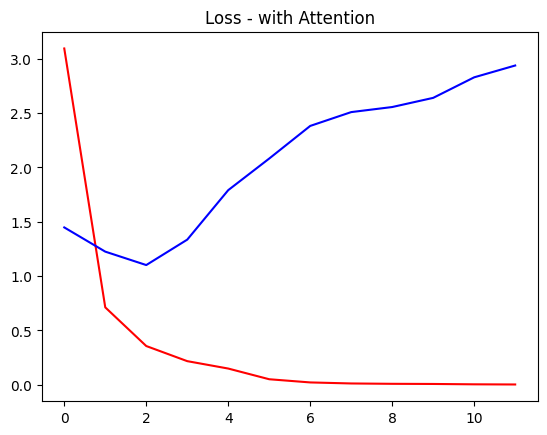

In [20]:
plt.title('Loss - with Attention')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

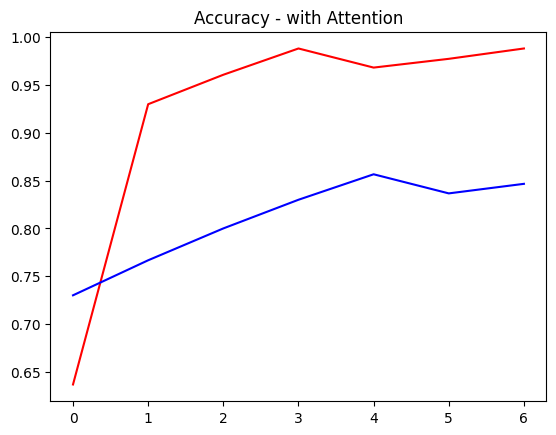

In [21]:
plt.title('Accuracy - with Attention')
plt.plot(histAtt.history['accuracy'], 'r')
plt.plot(histAtt.history['val_accuracy'], 'b')
plt.show()

In [22]:
tic=time.time()
test_loss, test_acc = modelAtt.evaluate(x_test)
toc=time.time()
test_time=toc-tic
print("Training Time = {} s".format(np.round(training_time, 1)))
print("Testing Time = {} ms".format(np.round(test_time*1000, 1)))
print('Test Loss = {:.2f} %:'.format(np.round(test_loss, 3)*100))
print('Test Accuracy = {:.2f} %:'.format(np.round(test_acc, 3)*100))

19/19 [==============================] - 0s 19ms/step - loss: 0.6919 - accuracy: 0.8467
Training Time = 53.6 s
Testing Time = 637.8 ms
Test Loss = 69.20 %:
Test Accuracy = 84.70 %:
